# Determine whether a patient admitted to an ICU has been diagnosed with Diabetes Mellitus in the first 24 hours of intenseive care.

In [1]:
# Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
import sqlalchemy
from sqlalchemy import create_engine
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session

## Connect to SQLite database

In [2]:
# Create engine, connect to database

engine = create_engine("sqlite:///Database/diabetes.sqlite")

# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

# Save references to each table
demographics = Base.classes.demographics
vitals = Base.classes.vitals
labs = Base.classes.labs
vitals = Base.classes.vitals


In [3]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['APACHE_comorbidity', 'demographics', 'labs', 'vitals']

In [4]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [5]:
diabetes_df = pd.read_sql("SELECT * FROM demographics join vitals on demographics.encounter_id = vitals.encounter_id join labs on demographics.encounter_id = labs.encounter_id join apache_comorbidity on demographics.encounter_id = apache_comorbidity.encounter_id;", engine)
print(diabetes_df.shape)
diabetes_df 

(130157, 139)


,encounter_id,hospital_id,age,bmi,elective_surgery,ethnicity,gender,height,hospital_admit_source,icu_admit_source,...,h1_wbc_min,encounter_id,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,214826,118,68.0,22.73280282,0,Caucasian,M,180.3,Floor,Floor,...,NaN,214826,0,0,0,0,0,0,0,1
1,246060,81,77.0,27.421875,0,Caucasian,F,160.0,Floor,Floor,...,12.7,246060,0,0,0,0,0,0,0,1
2,276985,118,25.0,31.95274882,0,Caucasian,F,172.7,Emergency Department,Accident & Emergency,...,NaN,276985,0,0,0,0,0,0,0,0
3,262220,118,81.0,22.63554823,1,Caucasian,F,165.1,Operating Room,Operating Room / Recovery,...,8.8,262220,0,0,0,0,0,0,0,0
4,201746,33,19.0,None,0,Caucasian,M,188.0,None,Accident & Emergency,...,NaN,201746,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130152,164758,7,50.0,29.28725559,0,Caucasian,M,175.3,Emergency Department,Accident & Emergency,...,NaN,164758,0,0,0,0,0,0,0,0
130153,197653,7,79.0,29.65343307,0,Caucasian,F,162.6,Direct Admit,Accident & Emergency,...,NaN,197653,0,0,0,0,0,0,0,0
130154,219719,7,73.0,32.26537065,0,African American,M,177.8,Emergency Department,Accident & Emergency,...,41.8,219719,0,0,0,0,0,0,0,1
130155,222562,170,81.0,24.40857925,0,Caucasian,M,185.4,Emergency Department,Accident & Emergency,...,NaN,222562,0,0,0,0,0,0,0,0


## Preprocessing the dataset

In [6]:
# Use columns the following relevant columns to predict diabetes mellitus
train_df = diabetes_df[['age', 'bmi', 'ethnicity', 'gender', 'height', 'weight', 'd1_glucose_max', 'd1_mbp_max', 'aids', 'cirrhosis', 'hepatic_failure', 'immunosuppression', 'leukemia', 'lymphoma', 'solid_tumor_with_metastasis','diabetes_mellitus']]
train_df

,age,bmi,ethnicity,gender,height,weight,d1_glucose_max,d1_mbp_max,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
0,68.0,22.73280282,Caucasian,M,180.3,73.9,168.0,89.0,0,0,0,0,0,0,0,1
1,77.0,27.421875,Caucasian,F,160.0,70.2,145.0,120.0,0,0,0,0,0,0,0,1
2,25.0,31.95274882,Caucasian,F,172.7,95.3,NaN,102.0,0,0,0,0,0,0,0,0
3,81.0,22.63554823,Caucasian,F,165.1,61.7,185.0,84.0,0,0,0,0,0,0,0,0
4,19.0,None,Caucasian,M,188.0,NaN,NaN,104.0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130152,50.0,29.28725559,Caucasian,M,175.3,90.0,NaN,120.0,0,0,0,0,0,0,0,0
130153,79.0,29.65343307,Caucasian,F,162.6,78.4,139.0,125.0,0,0,0,0,0,0,0,0
130154,73.0,32.26537065,African American,M,177.8,102.0,346.0,110.0,0,0,0,0,0,0,0,1
130155,81.0,24.40857925,Caucasian,M,185.4,83.9,156.0,97.0,0,0,0,0,0,0,0,0


In [7]:
train_df.isnull().sum()

age                            4988
bmi                            4490
ethnicity                      1587
gender                           66
height                         2077
weight                         3463
d1_glucose_max                 8243
d1_mbp_max                      327
aids                              0
cirrhosis                         0
hepatic_failure                   0
immunosuppression                 0
leukemia                          0
lymphoma                          0
solid_tumor_with_metastasis       0
diabetes_mellitus                 0
dtype: int64

In [8]:
train_df.dtypes

age                            float64
bmi                             object
ethnicity                       object
gender                          object
height                         float64
weight                         float64
d1_glucose_max                 float64
d1_mbp_max                     float64
aids                             int64
cirrhosis                        int64
hepatic_failure                  int64
immunosuppression                int64
leukemia                         int64
lymphoma                         int64
solid_tumor_with_metastasis      int64
diabetes_mellitus                int64
dtype: object

In [9]:
# change 'bmi' from object to float
train_df["bmi"] = train_df.bmi.astype(float)

/Users/sydney/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
# get value counts for 'gender'
train_df.gender.value_counts()

M    70518
F    59573
Name: gender, dtype: int64

In [11]:
# get value counts for 'ethnicity'
train_df.ethnicity.value_counts()

Caucasian           100236
African American     13911
Other/Unknown         6261
Hispanic              5049
Asian                 2198
tive American          915
Name: ethnicity, dtype: int64

In [12]:
# change NaN in 'ethnicity' to other/unknown
train_df['ethnicity'].fillna(value='Other/Unknown', inplace=True)


/Users/sydney/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/pandas/core/series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


In [13]:
# get value counts for 'ethnicity' again
train_df.ethnicity.value_counts()

Caucasian           100236
African American     13911
Other/Unknown         7848
Hispanic              5049
Asian                 2198
tive American          915
Name: ethnicity, dtype: int64

In [14]:
# drop all NaN values
train_df = train_df.dropna()

In [15]:
train_df.shape

(113363, 16)

In [16]:
# check correlation of features
train_df.corr()

,age,bmi,height,weight,d1_glucose_max,d1_mbp_max,aids,cirrhosis,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,diabetes_mellitus
age,1.000000,-0.080928,-0.115533,-0.124069,0.013701,-0.002479,-0.029320,-0.027930,-0.021860,0.020193,0.027893,0.023003,0.025195,0.075210
bmi,-0.080928,1.000000,-0.068630,0.878453,0.095824,0.062048,-0.022210,-0.006600,-0.003491,-0.035153,-0.014149,-0.010712,-0.044231,0.168091
height,-0.115533,-0.068630,1.000000,0.379432,-0.015834,0.019890,0.008104,0.013455,0.009804,-0.001304,0.003618,0.003516,0.003007,-0.008533
weight,-0.124069,0.878453,0.379432,1.000000,0.084191,0.069052,-0.019408,-0.000499,0.001514,-0.033847,-0.012600,-0.008496,-0.041014,0.153661
d1_glucose_max,0.013701,0.095824,-0.015834,0.084191,1.000000,0.025267,-0.010185,-0.008046,-0.010001,-0.006905,-0.004431,-0.002438,-0.016167,0.401457
d1_mbp_max,-0.002479,0.062048,0.019890,0.069052,0.025267,1.000000,0.006705,-0.024170,-0.030079,-0.014419,-0.010468,-0.010930,-0.021097,0.018093
aids,-0.029320,-0.022210,0.008104,-0.019408,-0.010185,0.006705,1.000000,0.007725,0.002571,0.015766,-0.002914,0.009809,-0.003140,-0.011425
cirrhosis,-0.027930,-0.006600,0.013455,-0.000499,-0.008046,-0.024170,0.007725,1.000000,0.544511,0.000017,-0.003672,-0.002569,-0.002767,0.011815
hepatic_failure,-0.021860,-0.003491,0.009804,0.001514,-0.010001,-0.030079,0.002571,0.544511,1.000000,0.002937,-0.000272,-0.002390,0.005009,0.006611
immunosuppression,0.020193,-0.035153,-0.001304,-0.033847,-0.006905,-0.014419,0.015766,0.000017,0.002937,1.000000,0.137938,0.100700,0.280764,-0.005516


<AxesSubplot:>

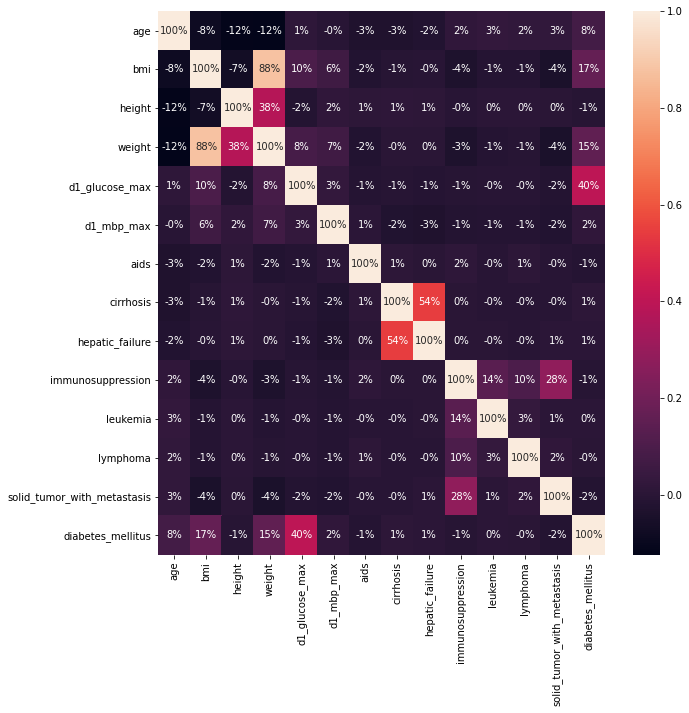

In [17]:
# visualize the correlation
plt.figure(figsize = (10,10))
sb.heatmap(train_df.corr(), annot=True, fmt='.0%')

In [18]:
# Binary encoding using Pandas (multiple columns)
train_encoded = pd.get_dummies(train_df, columns=["ethnicity", "gender"])
train_encoded

,age,bmi,height,weight,d1_glucose_max,d1_mbp_max,aids,cirrhosis,hepatic_failure,immunosuppression,...,solid_tumor_with_metastasis,diabetes_mellitus,ethnicity_African American,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Other/Unknown,ethnicity_tive American,gender_F,gender_M
0,68.0,22.732803,180.3,73.9,168.0,89.0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
1,77.0,27.421875,160.0,70.2,145.0,120.0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
3,81.0,22.635548,165.1,61.7,185.0,84.0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
5,67.0,27.555611,190.5,100.0,156.0,127.0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,1
6,59.0,57.451002,165.1,156.6,197.0,117.0,0,0,0,0,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130151,50.0,20.324301,165.1,55.4,182.0,99.0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0
130153,79.0,29.653433,162.6,78.4,139.0,125.0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
130154,73.0,32.265371,177.8,102.0,346.0,110.0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,1
130155,81.0,24.408579,185.4,83.9,156.0,97.0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


## Split and Train data

In [19]:
# use X as features and y as target 
X = train_encoded.drop(columns="diabetes_mellitus")
y = train_encoded["diabetes_mellitus"]

# split data into 75% training and 25% testing 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25,
                                                    random_state=1)
X_train.shape

(85022, 21)

### Logistic Regression model

In [20]:
# create a logistic regression model
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=2000,
                                random_state=1)


In [21]:
# fit model with training data
classifier.fit(X_train, y_train)

LogisticRegression(max_iter=2000, random_state=1)

In [22]:
# make prediction
y_pred = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
results.head(50)


,Prediction,Actual
0,1,1
1,0,0
2,1,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [23]:
# print accuracy score
print(accuracy_score(y_test, y_pred))

0.7889982710560672


In [24]:
# print confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[20701  1041]
 [ 4939  1660]]


In [25]:
# print classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.81      0.95      0.87     21742
           1       0.61      0.25      0.36      6599

    accuracy                           0.79     28341
   macro avg       0.71      0.60      0.62     28341
weighted avg       0.76      0.79      0.75     28341



### Decision Tree model

In [26]:
from sklearn import tree
tree = tree.DecisionTreeClassifier()
tree = tree.fit(X_train, y_train)

In [27]:
# Making predictions using the testing data
y_pred = tree.predict(X_test)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
results.head(50)

,Prediction,Actual
0,1,1
1,0,0
2,1,0
3,0,0
4,1,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [28]:
# print accuracy score
print(accuracy_score(y_test, y_pred))

0.7163826258777036


In [29]:
# print confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[17589  4153]
 [ 3885  2714]]


In [30]:
# print classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.81      0.81     21742
           1       0.40      0.41      0.40      6599

    accuracy                           0.72     28341
   macro avg       0.61      0.61      0.61     28341
weighted avg       0.72      0.72      0.72     28341



### Random Forest model

In [31]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, random_state=1)
forest = forest.fit(X_train, y_train)

In [32]:
# Making predictions using the testing data.
y_pred = forest.predict(X_test)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)
results.head(50)

,Prediction,Actual
0,0,1
1,0,0
2,1,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


In [33]:
# print accuracy score
print(accuracy_score(y_test, y_pred))

0.7880808722345718


In [34]:
# print confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

[[19991  1751]
 [ 4255  2344]]


In [35]:
# print classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.82      0.92      0.87     21742
           1       0.57      0.36      0.44      6599

    accuracy                           0.79     28341
   macro avg       0.70      0.64      0.65     28341
weighted avg       0.77      0.79      0.77     28341



## Additional training with model of our choice: Logistic Regression Model

We will scale the features in our dataset by converting all numerical data which are present in wide range into the same scale. 

In [67]:
# use X as features and y as target 
X = train_encoded.drop(columns="diabetes_mellitus")
y = train_encoded["diabetes_mellitus"]

# split data into 75% training and 25% testing 
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.25,
                                                    random_state=1)

In [68]:
# Creating the scaler instance
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [69]:
# Fitting the scaler
X_scaler = scaler.fit(X_train)


In [70]:
# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)


In [71]:
# create a logistic regression model
classifier = LogisticRegression(solver='lbfgs',
                                max_iter=2000,
                                random_state=1)


# fit model with training data
classifier.fit(X_train_scaled, y_train)

# make prediction
y_pred = classifier.predict(X_test_scaled)
results = pd.DataFrame({"Prediction": y_pred, "Actual": y_test}).reset_index(drop=True)


# print accuracy score
print(accuracy_score(y_test, y_pred))

# print confusion matrix
matrix = confusion_matrix(y_test, y_pred)
print(matrix)

# print classification report
report = classification_report(y_test, y_pred)
print(report)

0.7888571327758371
[[20705  1037]
 [ 4947  1652]]
              precision    recall  f1-score   support

           0       0.81      0.95      0.87     21742
           1       0.61      0.25      0.36      6599

    accuracy                           0.79     28341
   macro avg       0.71      0.60      0.61     28341
weighted avg       0.76      0.79      0.75     28341

